Author:
        
        PARK, JunHo, junho@ccnets.org

        
        KIM, JeongYoong, jeongyoong@ccnets.org
        
    COPYRIGHT (c) 2024. CCNets. All Rights reserved.

In [1]:
import sys

path_append = "../" # Go up one directory from where you are.
sys.path.append(path_append) 

from nn.utils.init import set_random_seed
set_random_seed(0)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision.datasets as dset
from torchvision import transforms

# import albumentations
n_img_sz = 64
# Load the CelebA dataset for training. Specify the root directory where the dataset is located
trainset = dset.CelebA(root=path_append + '../data/celeba', split = "train", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors,
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= True)

testset = dset.CelebA(root=path_append + '../data/celeba', split = "test", transform=transforms.Compose([
                            transforms.Resize(n_img_sz), # Transformations include resizing the images to `n_img_sz`
                            transforms.CenterCrop(n_img_sz), # Center cropping to the same size
                            transforms.ToTensor(), # Converting the images to tensors
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalizing the pixel values to have a mean and standard deviation of 0.5 across all channels.
                        ]), download= True)    

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainset = torch.utils.data.Subset(trainset, range(0, 40000))
testset = torch.utils.data.Subset(testset, range(0, 10000))

In [4]:
label_list = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 
              'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 
              'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 
              'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 
              'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young' ]
male_and_smiling_attributes = torch.tensor([label_list.index('Male'), label_list.index('Smiling')])
eyeglasses_and_young_attributes = torch.tensor([label_list.index('Eyeglasses'), label_list.index('Young')])

In [5]:
# Custom dataset class for CelebA dataset
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CausalModelDataset(Dataset):
    def __init__(self, dataset, selected_attributes):
        self.dataset = dataset
        self.selected_attributes = selected_attributes
    
    def __getitem__(self, index):
        X, y = self.dataset[index]
        y = torch.index_select(y.unsqueeze(0), 1, self.selected_attributes).squeeze(0)
        return X, y
    
    def __len__(self):
        return len(self.dataset)

class EncodingDataset(Dataset):
    def __init__(self, dataset, attributes, causal_model):
        self.dataset = dataset
        self.attributes = attributes
        self.causal_model = causal_model

        data_loader = DataLoader(dataset=dataset, batch_size=256, shuffle=False, drop_last=False)
        list_encodings = []
        list_labels = []
        with torch.no_grad():
            for images, labels in data_loader:
                images = images.to(self.causal_model.device)
                encodings = self.causal_model.explain(images).detach().cpu()
                attributes = labels[:, self.attributes]
                list_encodings.append(encodings)
                list_labels.append(attributes)
        self.encodings = torch.cat(list_encodings, dim=0)
        self.labels = torch.cat(list_labels, dim=0)
        
    def __getitem__(self, index):
        return self.encodings[index], self.labels[index]

    def __len__(self):
        return len(self.dataset)

In [6]:
from tools.setting.ml_params import MLParameters
from tools.setting.data_config import DataConfig
from trainer_hub import TrainerHub
num_classes = 2
data_config = DataConfig(dataset_name = 'celebA', task_type='multi_label_classification', obs_shape=[3, n_img_sz, n_img_sz], \
                        label_size=num_classes)

#  Set training configuration from the AlgorithmConfig class, returning them as a Namespace object.
ml_params = MLParameters(ccnet_network = 'resnet')

ml_params.training.num_epoch = 1
ml_params.model.ccnet_config.num_layers = 4
ml_params.algorithm.reset_pretrained = True

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:
from nn.tabnet import TabNet 
from tools.setting.ml_params import ModelConfig

class AttributeClassifier(torch.nn.Module):
    def __init__(self, input_size, output_size, num_layers=3, hidden_size=256):
        super(AttributeClassifier, self).__init__()
        
        model_config = ModelConfig('tabnet')
        model_config.num_layers = num_layers
        model_config.d_model = hidden_size
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Create a list to hold all layers
        layers = []
        
        # Input layer
        layers.append(torch.nn.Linear(input_size, hidden_size))
        layers.append(torch.nn.ReLU())
        
        ## Add TabNet layers
        layers.append(TabNet(model_config))
        layers.append(torch.nn.ReLU())

        # Output layer
        layers.append(torch.nn.Linear(hidden_size, output_size))
        
        # Register all layers
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return torch.sigmoid(x)

In [8]:
# Function to train classifier
DECAY_RATE = 0.01
ITERATION_100K = 100000
gamma = pow(DECAY_RATE, 1 / ITERATION_100K)    

def train_classifier(model, trainset, num_epochs=2, gamma=gamma):
    model.train()
    train_loader = DataLoader(trainset, batch_size=64, shuffle=True)    
    len_loader = len(train_loader)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    for epoch in range(num_epochs):
        sum_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(data)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            sum_loss += loss.item()
        print("Epoch: ", epoch, "Loss: ", sum_loss / len_loader)
    print("Learning rate: ", optimizer.param_groups[0]['lr'])

In [9]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt

# Function to evaluate classifier
def test_classifier(model, dataset):
    model.eval()
    all_preds = []
    all_labels = []
    
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data)
            preds = torch.sigmoid(outputs).round()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return accuracy, f1

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

def plot_accuracy(ax, epochs, selected_results_dict, none_selected_results_dict):
    ax.cla()
    ax.plot(epochs, selected_results_dict['accuracy'], label='Selected Attributes Accuracy')
    ax.plot(epochs, none_selected_results_dict['accuracy'], label='None Selected Attributes Accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('None Selected Attribute score should be higher')
    ax.legend()

def plot_f1_score(ax, epochs, selected_results_dict, none_selected_results_dict):
    ax.cla()
    ax.plot(epochs, selected_results_dict['f1_score'], label='Selected Attributes F1 Score')
    ax.plot(epochs, none_selected_results_dict['f1_score'], label='None Selected Attributes F1 Score')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1 Score')
    ax.set_title('Selected Attribute score should be lower')
    ax.legend()

In [11]:
import matplotlib.pyplot as plt
trainer_hub = TrainerHub(ml_params, data_config, device, use_print = True)
encoding_size = data_config.explain_size
causal_model = trainer_hub.ccnet

selected_classifier = AttributeClassifier(encoding_size, num_classes).to(device)
none_selected_classifier = AttributeClassifier(encoding_size, num_classes).to(device)

Trainer Name: causal_trainer


ModelParameters Parameters:


,ccnet_config,ccnet_network,encoder_config,encoder_network
0,See details below,resnet,None,none



Detailed ccnet_config Configuration:


,ccnet_config_model_name,ccnet_config_num_layers,ccnet_config_d_model,ccnet_config_dropout,ccnet_config_obs_shape,ccnet_config_condition_dim,ccnet_config_z_dim
0,resnet,4,256,0.05,"[3, 64, 64]",2,128


TrainingParameters Parameters:


,batch_size,max_iters,max_seq_len,min_seq_len,num_epoch
0,64,100000,None,None,1


OptimizationParameters Parameters:


,clip_grad_range,decay_rate_100k,learning_rate,max_grad_norm,scheduler_type
0,None,0.05,0.0002,1.0,exponential


AlgorithmParameters Parameters:


,enable_diffusion,error_function,reset_pretrained
0,False,mse,True


DataConfig Parameters:


,dataset_name,task_type,obs_shape,label_size,explain_size,explain_layer,state_size,show_image_indices
0,celeba,multi_label_classification,"[3, 64, 64]",2,128,tanh,None,None


In [12]:
def test_classifiers(epoch, axs, testset_selected, testset_none_selected, selected_results, none_selected_results):
    print(f"Testing causal classifier on selected attributes at epoch {epoch}...")
    selected_acc, selected_f1 = test_classifier(selected_classifier, testset_selected)
    selected_results['accuracy'].append(selected_acc)
    selected_results['f1_score'].append(selected_f1)

    print(f"Testing classifier on none selected attributes at epoch {epoch}...")
    none_selected_acc, none_selected_f1 = test_classifier(none_selected_classifier, testset_none_selected)
    none_selected_results['accuracy'].append(none_selected_acc)
    none_selected_results['f1_score'].append(none_selected_f1)

    # Update plots
    epochs = range(1, len(selected_results['accuracy']) + 1)
    
    plot_accuracy(axs[0], epochs, selected_results, none_selected_results)
    plot_f1_score(axs[1], epochs, selected_results, none_selected_results)


In [13]:
def display_plot(fig):
    plt.tight_layout()
    clear_output(wait=True)
    display(fig, display_id='fig')
    plt.pause(0.1)  # Pause to allow the plot to update

def update_annot(ind, line, annot):
    pos = line.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = f"{pos[0]:.2f}, {pos[1]:.2f}"
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event, fig, ax, line, annot):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind, line, annot)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

def initialize_plot():
    # Sample data
    x = np.linspace(0, 10, 100)
    y = np.sin(x)
    
    # Turn off interactive mode initially
    plt.ioff()
    
    # Create the figure and axes
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Create the scatter plot on the first subplot
    ax = axs[0]
    line = ax.scatter(x, y)
    
    # Annotate point
    annot = ax.annotate("", xy=(0,0), xytext=(20,20),
                        textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    
    # Connect the hover event
    fig.canvas.mpl_connect("motion_notify_event", lambda event: hover(event, fig, ax, line, annot))

    return fig, axs, ax, line, annot

In [14]:
def train_causal_model_and_classifiers(causal_model_selected_attributes, none_selected_attributes, num_epoch = 20):
    epoch = 0
    causal_model_dataset = CausalModelDataset(trainset, causal_model_selected_attributes)
    
    # Initialize the plot
    fig, axs, ax, line, annot = initialize_plot()
    
    # Create dictionaries to store results
    selected_results_dict = {'accuracy': [], 'f1_score': []}
    none_selected_results_dict = {'accuracy': [], 'f1_score': []}

    for _ in range(1, num_epoch + 1):
        epoch += 1
        print(f"Training causal model at epoch {epoch}...")
        trainer_hub.train(causal_model_dataset)
        
        # Train and evaluate classifiers on the explanation datasets
        print("Training causal classifier on selected attributes...")
        trainset_selected_attributes = EncodingDataset(trainset, causal_model_selected_attributes, causal_model)
        testset_selected_attributes = EncodingDataset(testset, causal_model_selected_attributes, causal_model)

        train_classifier(selected_classifier, trainset_selected_attributes)

        print("Training classifier on none selected attributes...")
        trainset_none_selected_attributes = EncodingDataset(trainset, none_selected_attributes, causal_model)
        testset_none_selected_attributes = EncodingDataset(testset, none_selected_attributes, causal_model)    
        
        train_classifier(none_selected_classifier, trainset_none_selected_attributes)
        
        # Test classifiers
        test_classifiers(epoch, axs, testset_selected_attributes, testset_none_selected_attributes, selected_results_dict, none_selected_results_dict)
        
        # Update the plot
        display_plot(fig)

    plt.ioff()  # Turn off interactive mode
    plt.show()

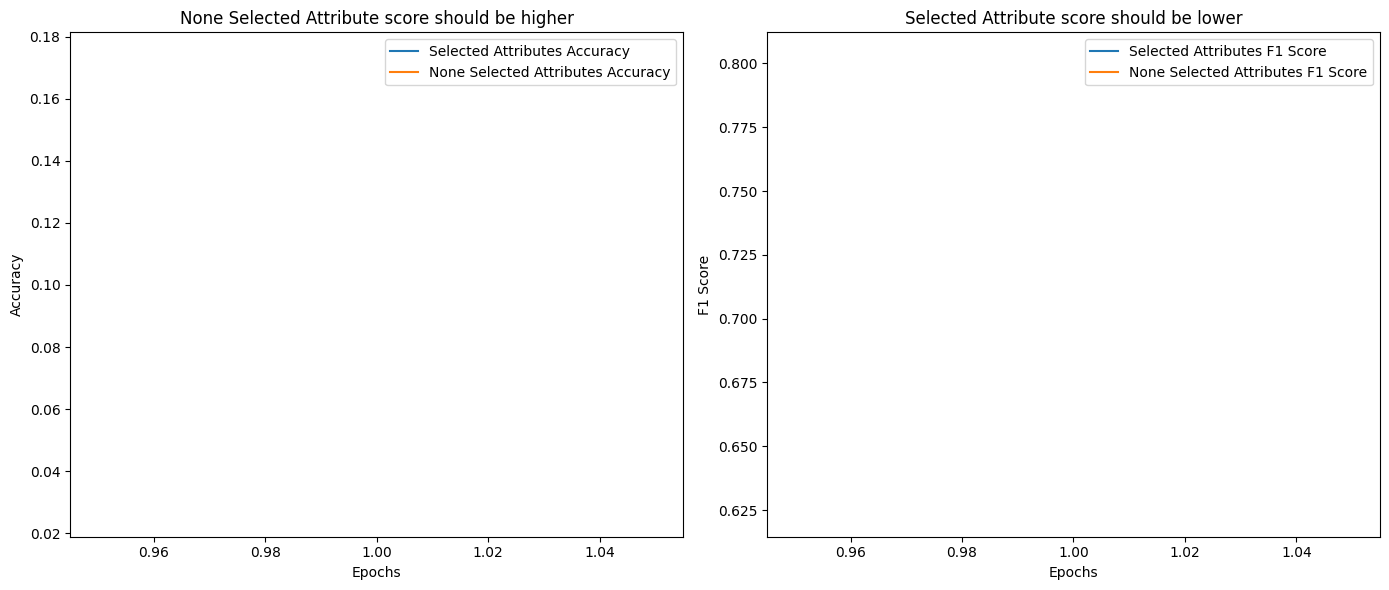

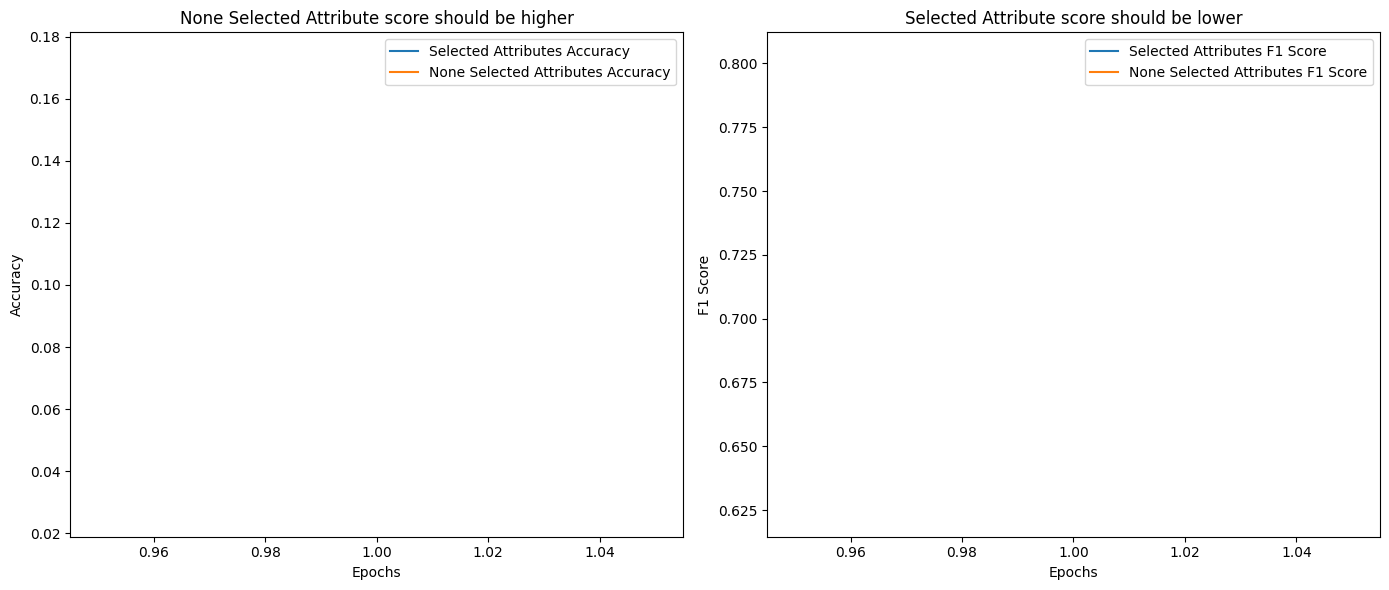

Training causal model at epoch 2...


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Iterations:   0%|          | 0/625 [00:00<?, ?it/s]

[0/1][75/625][Time 143.03]
Unified LR across all optimizers: 0.00019584377661232514
--------------------Training Metrics--------------------
CCNet:  Three Resnet
Inf: 0.0577	Gen: 0.2809	Rec: 0.2740	E: 0.0081	R: 0.0040	P: 0.2663
[0/1][175/625][Time 13.40]
Unified LR across all optimizers: 0.00019525795900462422
--------------------Training Metrics--------------------
CCNet:  Three Resnet
Inf: 0.0511	Gen: 0.2777	Rec: 0.2729	E: 0.0058	R: 0.0033	P: 0.2686
[0/1][275/625][Time 13.39]
Unified LR across all optimizers: 0.00019467389372357586
--------------------Training Metrics--------------------
CCNet:  Three Resnet
Inf: 0.0498	Gen: 0.2704	Rec: 0.2657	E: 0.0052	R: 0.0031	P: 0.2542
[0/1][375/625][Time 13.28]
Unified LR across all optimizers: 0.00019409157552753375
--------------------Training Metrics--------------------
CCNet:  Three Resnet
Inf: 0.0457	Gen: 0.2645	Rec: 0.2604	E: 0.0045	R: 0.0027	P: 0.2472
[0/1][475/625][Time 13.13]
Unified LR across all optimizers: 0.00019351099919053054
----

In [15]:
train_causal_model_and_classifiers(causal_model_selected_attributes = eyeglasses_and_young_attributes, none_selected_attributes = male_and_smiling_attributes, num_epoch = 20)

In [ ]:
train_causal_model_and_classifiers(causal_model_selected_attributes = male_and_smiling_attributes, none_selected_attributes = eyeglasses_and_young_attributes, num_epoch = 20)